In [1]:
!pip list

Package                               Version             
------------------------------------- --------------------
absl-py                               0.8.1               
adal                                  1.2.2               
alabaster                             0.7.11              
altair                                3.2.0               
anaconda-client                       1.7.2               
anaconda-navigator                    1.9.2               
anaconda-project                      0.8.2               
ansiwrap                              0.8.4               
antlr4-python3-runtime                4.7.2               
appdirs                               1.4.3               
applicationinsights                   0.11.9              
argcomplete                           1.10.0              
arrow                                 0.15.4              
asn1crypto                            0.24.0              
astor                                 0.8.0             

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import TimeGrouper
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [3]:
import azureml.core
from azureml.core import Experiment, Workspace

# Check core SDK version number
print("This notebook was created using version 1.0.2 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")
print("")


ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

This notebook was created using version 1.0.2 of the Azure ML SDK
You are currently using version 1.0.72 of the Azure ML SDK

Workspace name: ShivaMLservice
Azure region: westus2
Subscription id: 46668180-b0ad-4a49-bed9-88f16f315dce
Resource group: MLGroup


In [4]:
# Get an experiment object from Azure Machine Learning
experiment = Experiment(workspace=ws, name="arima_sales_forecast")

# Create a run object in the experiment
run =  experiment.start_logging()

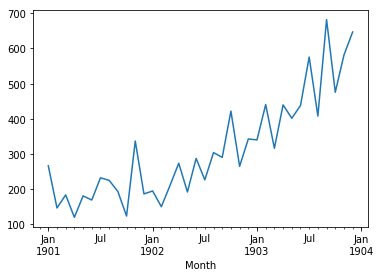

In [5]:
#Usually universal date_time standard is provided. In those few cases where it does not, specify your own date parsing function and use the date_parser argument.
def date_parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')


#squeeze=True reads it as series instead of data frame
series = pd.read_csv('./data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=date_parser)
series.plot()
plt.show()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  from ipykernel import kernelapp as app


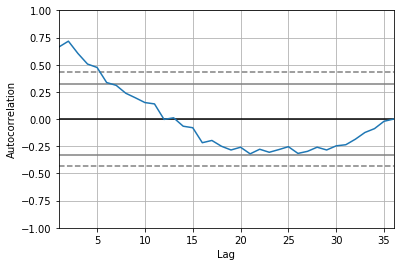

In [6]:
#suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.
autocorrelation_plot(series)
plt.show()
# there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

In [7]:
#mean and variance test to check if the series is stationary. Huge difference in mean and variance values imply it is not stationary
def mean_and_variance(X):
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    
mean_and_variance(series.values)

mean1=203.505556, mean2=421.694444
variance1=3187.747191, variance2=16141.266080


In [8]:
def fuller_test(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
    	print('\t%s: %.3f' % (key, value))
        
fuller_test(series.values)

# p-value is not less than 0.05, hence not stationary

ADF Statistic: 3.060142
p-value: 1.000000
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


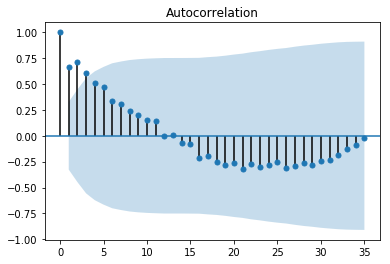

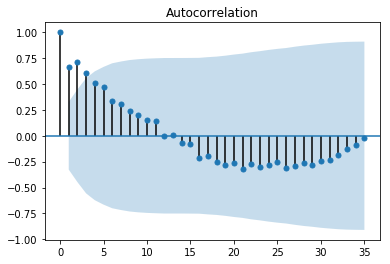

In [9]:
plot_acf(series)

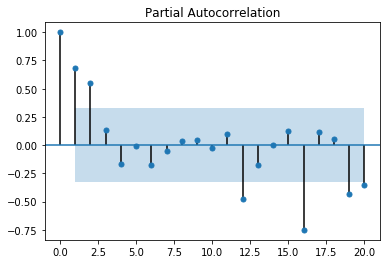

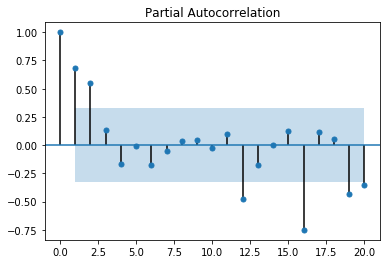

In [10]:
plot_pacf(series, lags=20)

In [45]:
#since there is no auto.arima function in Python, we can grid search arima model parameters

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error


In [46]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [48]:
# grid-search and evaluate parameters
import warnings
warnings.filterwarnings("ignore")

p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=52425.268
ARIMA(0, 0, 1) MSE=38145.144
ARIMA(0, 0, 2) MSE=23989.574
ARIMA(0, 1, 0) MSE=18003.173
ARIMA(0, 1, 1) MSE=9558.317
ARIMA(0, 2, 0) MSE=67339.808
ARIMA(0, 2, 1) MSE=18322.718
ARIMA(1, 0, 0) MSE=23112.903
ARIMA(1, 1, 0) MSE=7121.372
ARIMA(1, 1, 1) MSE=7003.685
ARIMA(1, 2, 0) MSE=18608.037
ARIMA(2, 0, 0) MSE=10264.017
ARIMA(2, 1, 0) MSE=5689.930
ARIMA(2, 1, 1) MSE=7759.710
ARIMA(2, 2, 0) MSE=9860.956
ARIMA(3, 1, 0) MSE=6998.943
ARIMA(3, 1, 1) MSE=7145.876
ARIMA(3, 2, 0) MSE=10513.281
ARIMA(4, 1, 0) MSE=6649.592
ARIMA(4, 1, 1) MSE=6796.300
ARIMA(4, 2, 0) MSE=7596.337
ARIMA(4, 2, 1) MSE=4694.874
ARIMA(5, 1, 0) MSE=6958.327
ARIMA(5, 2, 0) MSE=6710.513
Best ARIMA(4, 2, 1) MSE=4694.874


NameError: name 'r2_evaluate_models' is not defined

In [11]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

model = ARIMA(train, order=(4,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   21
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -117.816
Method:                       css-mle   S.D. of innovations             55.355
Date:                Sun, 12 Apr 2020   AIC                            249.631
Time:                        01:11:46   BIC                            256.943
Sample:                             2   HQIC                           251.218
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1186      0.619      1.808      0.091      -0.094       2.331
ar.L1.D2.y    -1.0880      0.228     -4.781      0.000      -1.534      -0.642
ar.L2.D2.y    -0.7512      0.306     -2.452      0.0

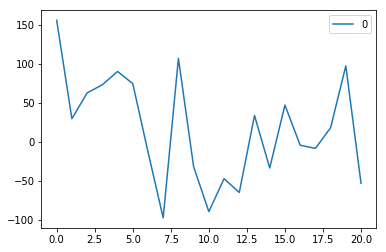

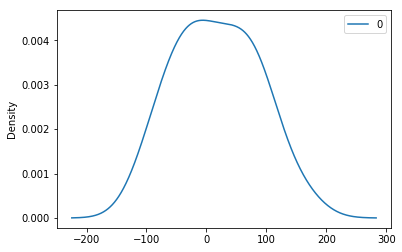

                0
count   21.000000
mean    16.542727
std     69.499361
min    -97.676327
25%    -33.562559
50%     18.170003
75%     73.307100
max    156.181367


In [12]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [13]:
predictions=model_fit.forecast(steps=13)[0]

mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test,predictions)
print('Test RMSE: %.3f' % rmse)
print('Test R2: %.3f' % r2)

Test RMSE: 89.897
Test R2: 0.376


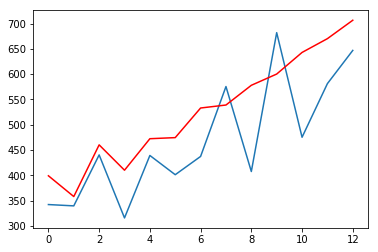

In [14]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=399.145062, expected=342.300000
predicted=354.296576, expected=339.700000
predicted=429.967785, expected=440.400000
predicted=392.634664, expected=315.900000
predicted=420.191793, expected=439.300000
predicted=397.585398, expected=401.300000
predicted=487.892639, expected=437.400000
predicted=434.160049, expected=575.500000
predicted=467.057681, expected=407.600000
predicted=568.083052, expected=682.000000
predicted=468.024750, expected=475.300000
predicted=687.491769, expected=581.300000
predicted=617.839208, expected=646.900000
Test RMSE: 89.897
Test R2: 0.637


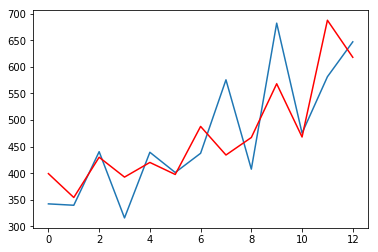

In [15]:
#### ROLLING FORECAST

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4,2,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test,predictions)
print('Test RMSE: %.3f' % rmse)
print('Test R2: %.3f' % r2)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [17]:
run.log('RMSE', rmse)
run.log('R2', r2)

In [20]:
from sklearn.externals import joblib

# Save the model to the outputs directory for capture
model_file_name = 'outputs/arima_model.pkl'

joblib.dump(value = model_fit, filename = model_file_name)

# upload the model file explicitly into artifacts 
run.upload_file(name = model_file_name, path_or_stream = model_file_name)

# Complete the run
run.complete()

In [24]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
arima_sales_forecast,6cd98127-cf8c-4f99-836d-6eb51ef59f87,,Running,Link to Azure Machine Learning studio,Link to Documentation


Huge difference in results between rolling forecast vs. multi-step forecasting. This is why deploying forecasting algorithms to production is very different from deploying other ML models. It wouldn't be prudent to deploy a static model and score it, as the concept of model serving doesn’t make sense for time series forecasting. The only way around this is to retrain your model every time you get new data. Note that this is not the same as continuous learning, where an already trained model is updated as new data comes in. In some cases, it is beneficial to actually retraining a new model from scratch everytime you want to generate a new forecast.

In [53]:
#additional grid-searching using R2 score

def r2_evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    r2 = r2_score(test, predictions)
    return r2

In [54]:
def r2_evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = 0, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    r2 = r2_evaluate_arima_model(dataset, order)
                    if r2 > best_score:
                        best_score, best_cfg = r2, order
                    print('ARIMA%s R2=%.3f' % (order,r2))
                except:
                    continue
    print('Best ARIMA%s R2=%.3f' % (best_cfg, best_score))

In [55]:
# grid-search and evaluate parameters
import warnings
warnings.filterwarnings("ignore")

p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
r2_evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) R2=-3.050
ARIMA(0, 0, 1) R2=-1.947
ARIMA(0, 0, 2) R2=-0.853
ARIMA(0, 1, 0) R2=-0.391
ARIMA(0, 1, 1) R2=0.262
ARIMA(0, 2, 0) R2=-4.203
ARIMA(0, 2, 1) R2=-0.416
ARIMA(1, 0, 0) R2=-0.786
ARIMA(1, 1, 0) R2=0.450
ARIMA(1, 1, 1) R2=0.459
ARIMA(1, 2, 0) R2=-0.438
ARIMA(2, 0, 0) R2=0.207
ARIMA(2, 1, 0) R2=0.560
ARIMA(2, 1, 1) R2=0.400
ARIMA(2, 2, 0) R2=0.238
ARIMA(3, 1, 0) R2=0.459
ARIMA(3, 1, 1) R2=0.448
ARIMA(3, 2, 0) R2=0.188
ARIMA(4, 1, 0) R2=0.486
ARIMA(4, 1, 1) R2=0.475
ARIMA(4, 2, 0) R2=0.413
ARIMA(4, 2, 1) R2=0.637
ARIMA(5, 1, 0) R2=0.462
ARIMA(5, 2, 0) R2=0.482
Best ARIMA(4, 2, 1) R2=0.637
